## Goals of this Jupyter notebook 
Implement linear regression model on a dataset, perform common tasks to understand, scale and select features.

## Outline
#### <a href='#data_description'>Data Description</a>
##### - Prior known results and research paper
#### <a href='#univariate_analysis'>Univariate analysis</a>
#### <a href='#bivariate_analysis'>Bivariate analysis</a>
#### <a href='#dummyregressor'>Dummy Regressor baseline</a>
#### <a href='#linear_regression'>Linear Regression</a>
#### <a href='#feature_selection'>Feature Selection</a>
##### <a href='#log_transform'> Log transformation of the target to create non-linear targets 

#### <a href='#regularization'>Regularization</a>
#### <a href='#p_values'>P-values, statistical testing of the feature coefficients and high multicollinearity</a>
##### -  <a href='#vif'>Variance inflation factor</a>
##### -  <a href='#residuals'> Residual Plot</a>
#### <a href='#non_linearity'>Dealing with Non-linearity</a>
##### -  <a href='#xgb'>XGBoost</a>
##### -  <a href='#gam'>GAM (generalized additive models) and interpretability</a>


<a id='data_description'></a>
### Data Description


The superconductivity data used in this notebook can be downloaded from UCI [here](http://archive.ics.uci.edu/ml/datasets/Superconductivty+Data).  
The `train.csv` file is used which contains 10 features for each of 8 compounds, including number of elements for a superconductor.  There are 21263 superconductors and the target value is the critical temperature.

The research paper that describes the process of extracting the features and modeling the data to predict critical temperatue is: [A Data-Driven Statistical Model for Predicting the Critical Temperature of a Superconductor](https://arxiv.org/pdf/1803.10260.pdf)
by Kam Hamidieh.

They had tried multiple regression models, but got the best results using XGBoost. They were *"able to assess the importance of the features in prediction accuracy. Features defined based on thermal conductivity, atomic radius, valence, electron affinity, and atomic mass are the most important features in predicting Tc. On the downside, simple conclusions such as the exact nature of the relationship between the features and Tc can’t be inferred from the XGBoost model."*

In [55]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest, anderson
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler
from sklearn.feature_selection import f_regression
import numpy as np
import warnings
#warnings.filterwarnings('ignore')

In [56]:
df=pd.read_csv("train.csv")
df.shape #(21263, 82)
df.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000
mean,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,44.391893,...,3.153127,3.056536,3.055885,1.295682,1.052841,2.041010,1.483007,0.839342,0.673987,34.421219
std,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,20.035430,...,1.191249,1.046257,1.174815,0.393155,0.380291,1.242345,0.978176,0.484676,0.455580,34.254362
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000210
25%,3.000000,72.458076,52.143839,58.041225,35.248990,0.966676,0.775363,78.512902,16.824174,32.890369,...,2.116732,2.279705,2.091251,1.060857,0.775678,1.000000,0.921454,0.451754,0.306892,5.365000
50%,4.000000,84.922750,60.696571,66.361592,39.918385,1.199541,1.146783,122.906070,26.636008,45.123500,...,2.618182,2.615321,2.434057,1.368922,1.166532,2.000000,1.063077,0.800000,0.500000,20.000000
75%,5.000000,100.404410,86.103540,78.116681,73.113234,1.444537,1.359418,154.119320,38.356908,59.322812,...,4.026201,3.727919,3.914868,1.589027,1.330801,3.000000,1.918400,1.200000,1.020436,63.000000
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000,185.000000


<a id='univariate_analysis'></a>
### Univariate analysis
Distribution of the target variable, and the features.  The distributions do not appear normal for any.

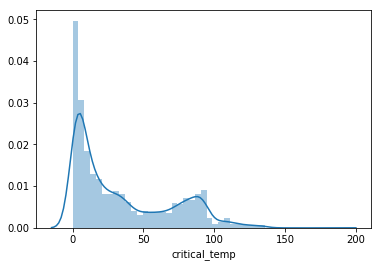

In [57]:
sns.distplot(df.critical_temp)

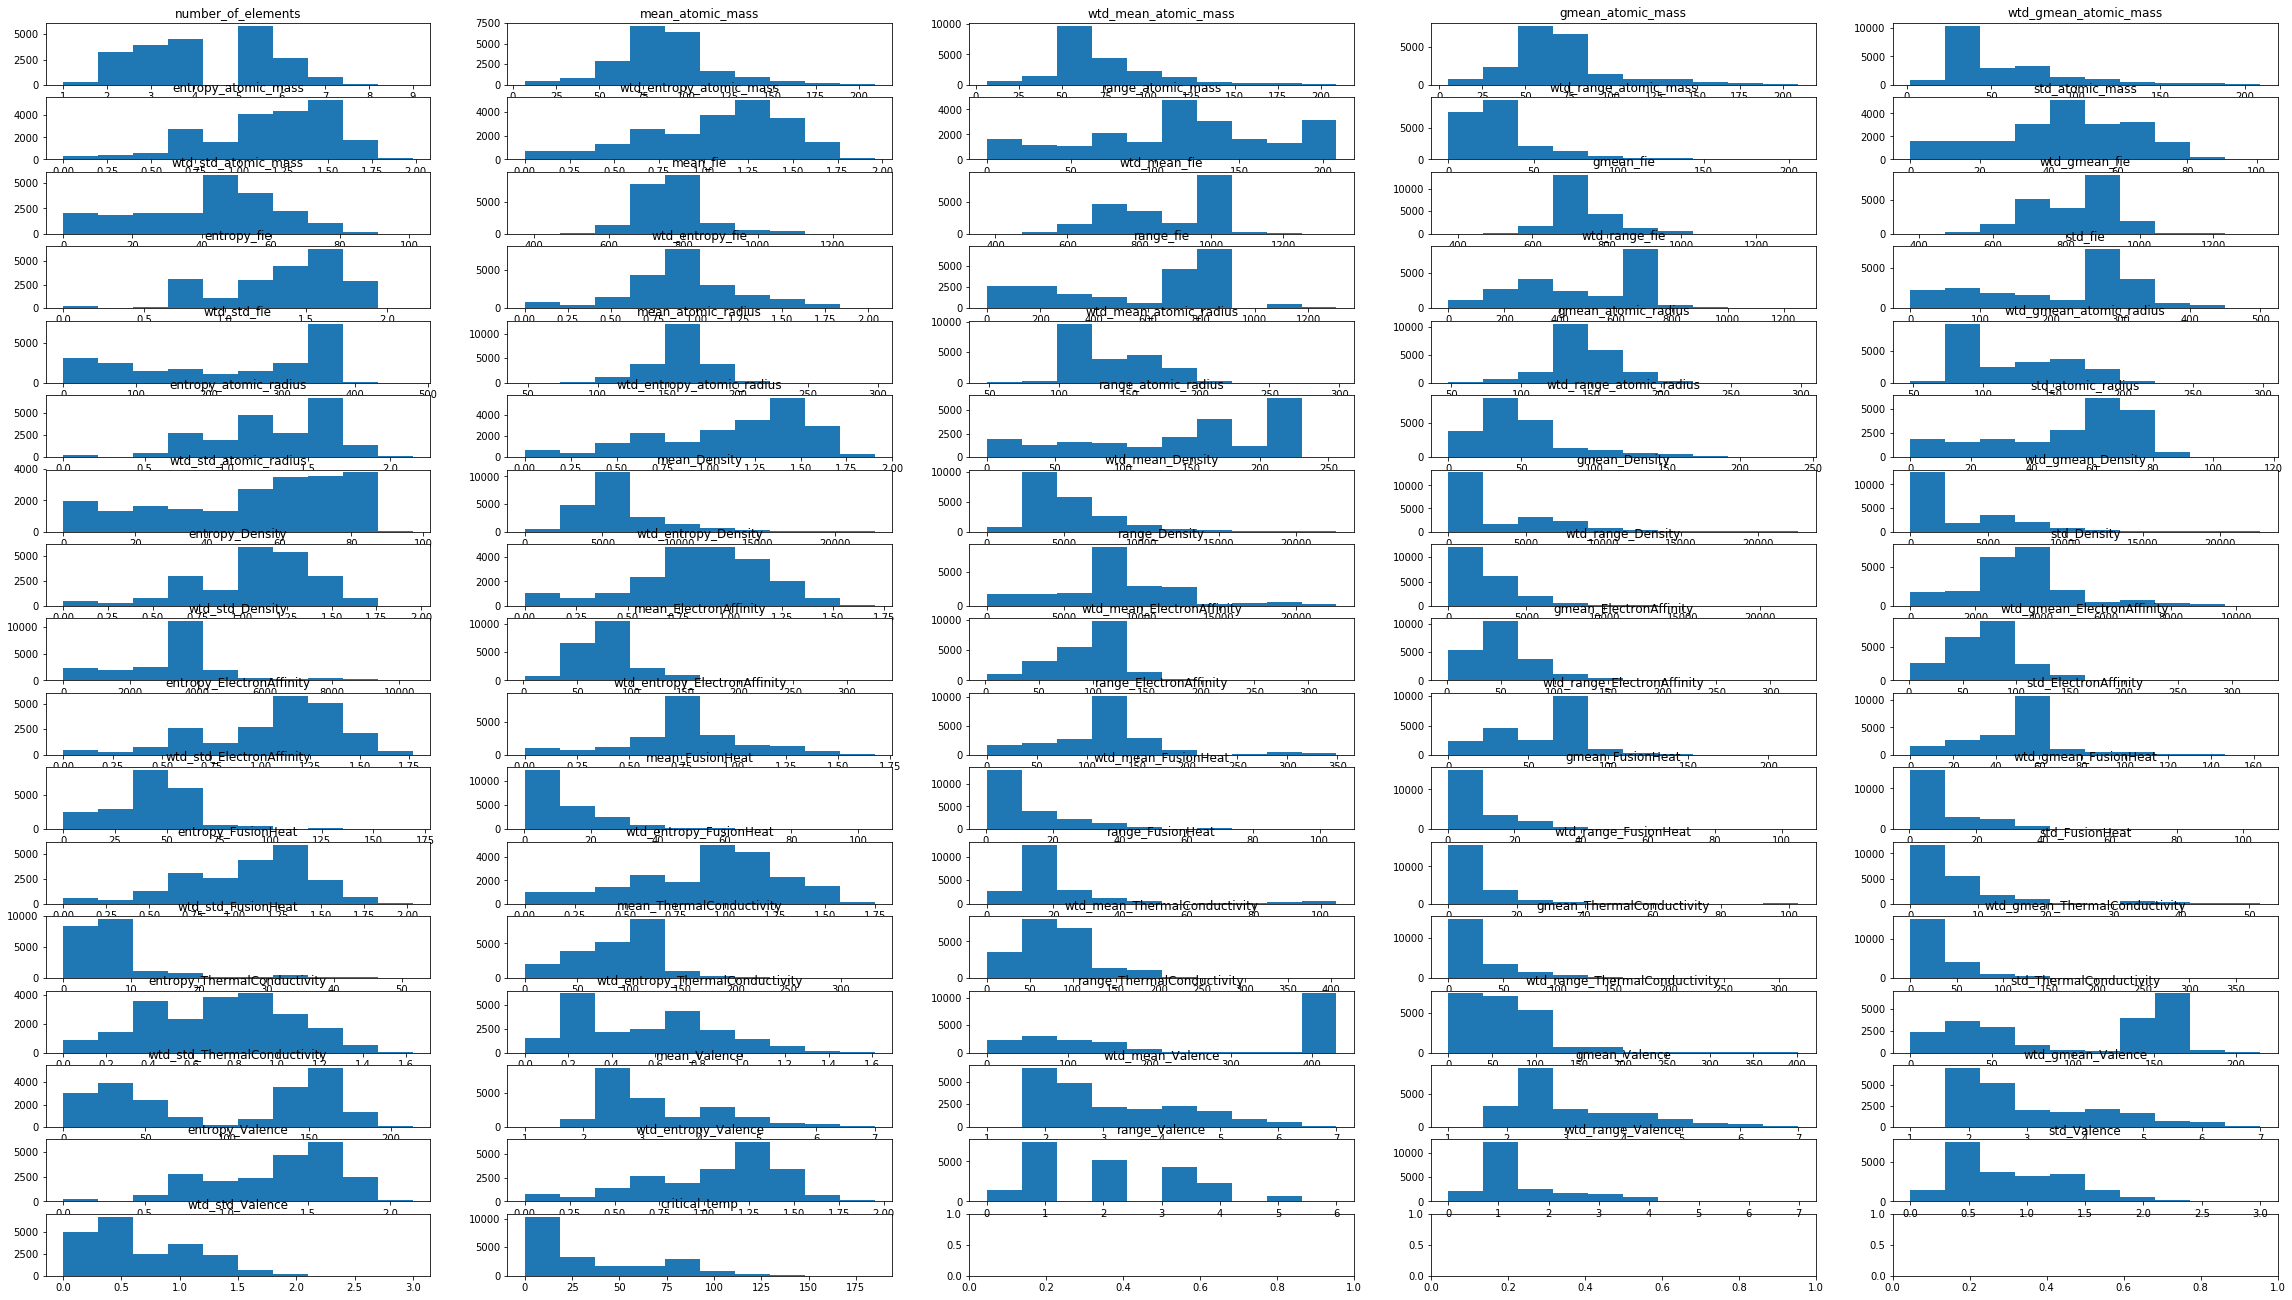

In [58]:
#82 features, 
fig, axes = plt.subplots(17, 5, figsize=(40,30))
fig.subplots_adjust(bottom=0.3)

for i, col in enumerate(df.columns):
    plt.subplot(17, 5, i+1)
    plt.hist(df[col])
    plt.title(col)

<a id='bivariate_analysis'></a>
### Bivariate analysis

Performing some visual checks on the relationship of the number of elements to the critical temperature, and one element and its' 10 feature to the critical temperature.

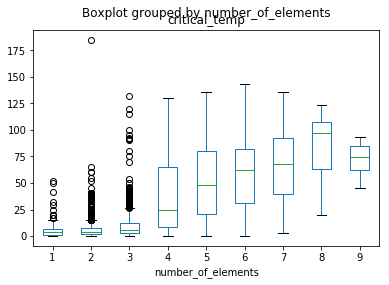

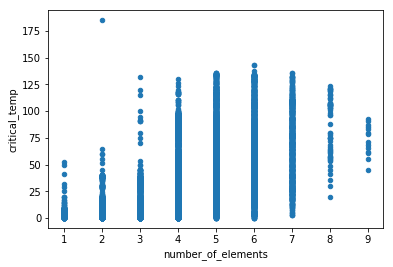

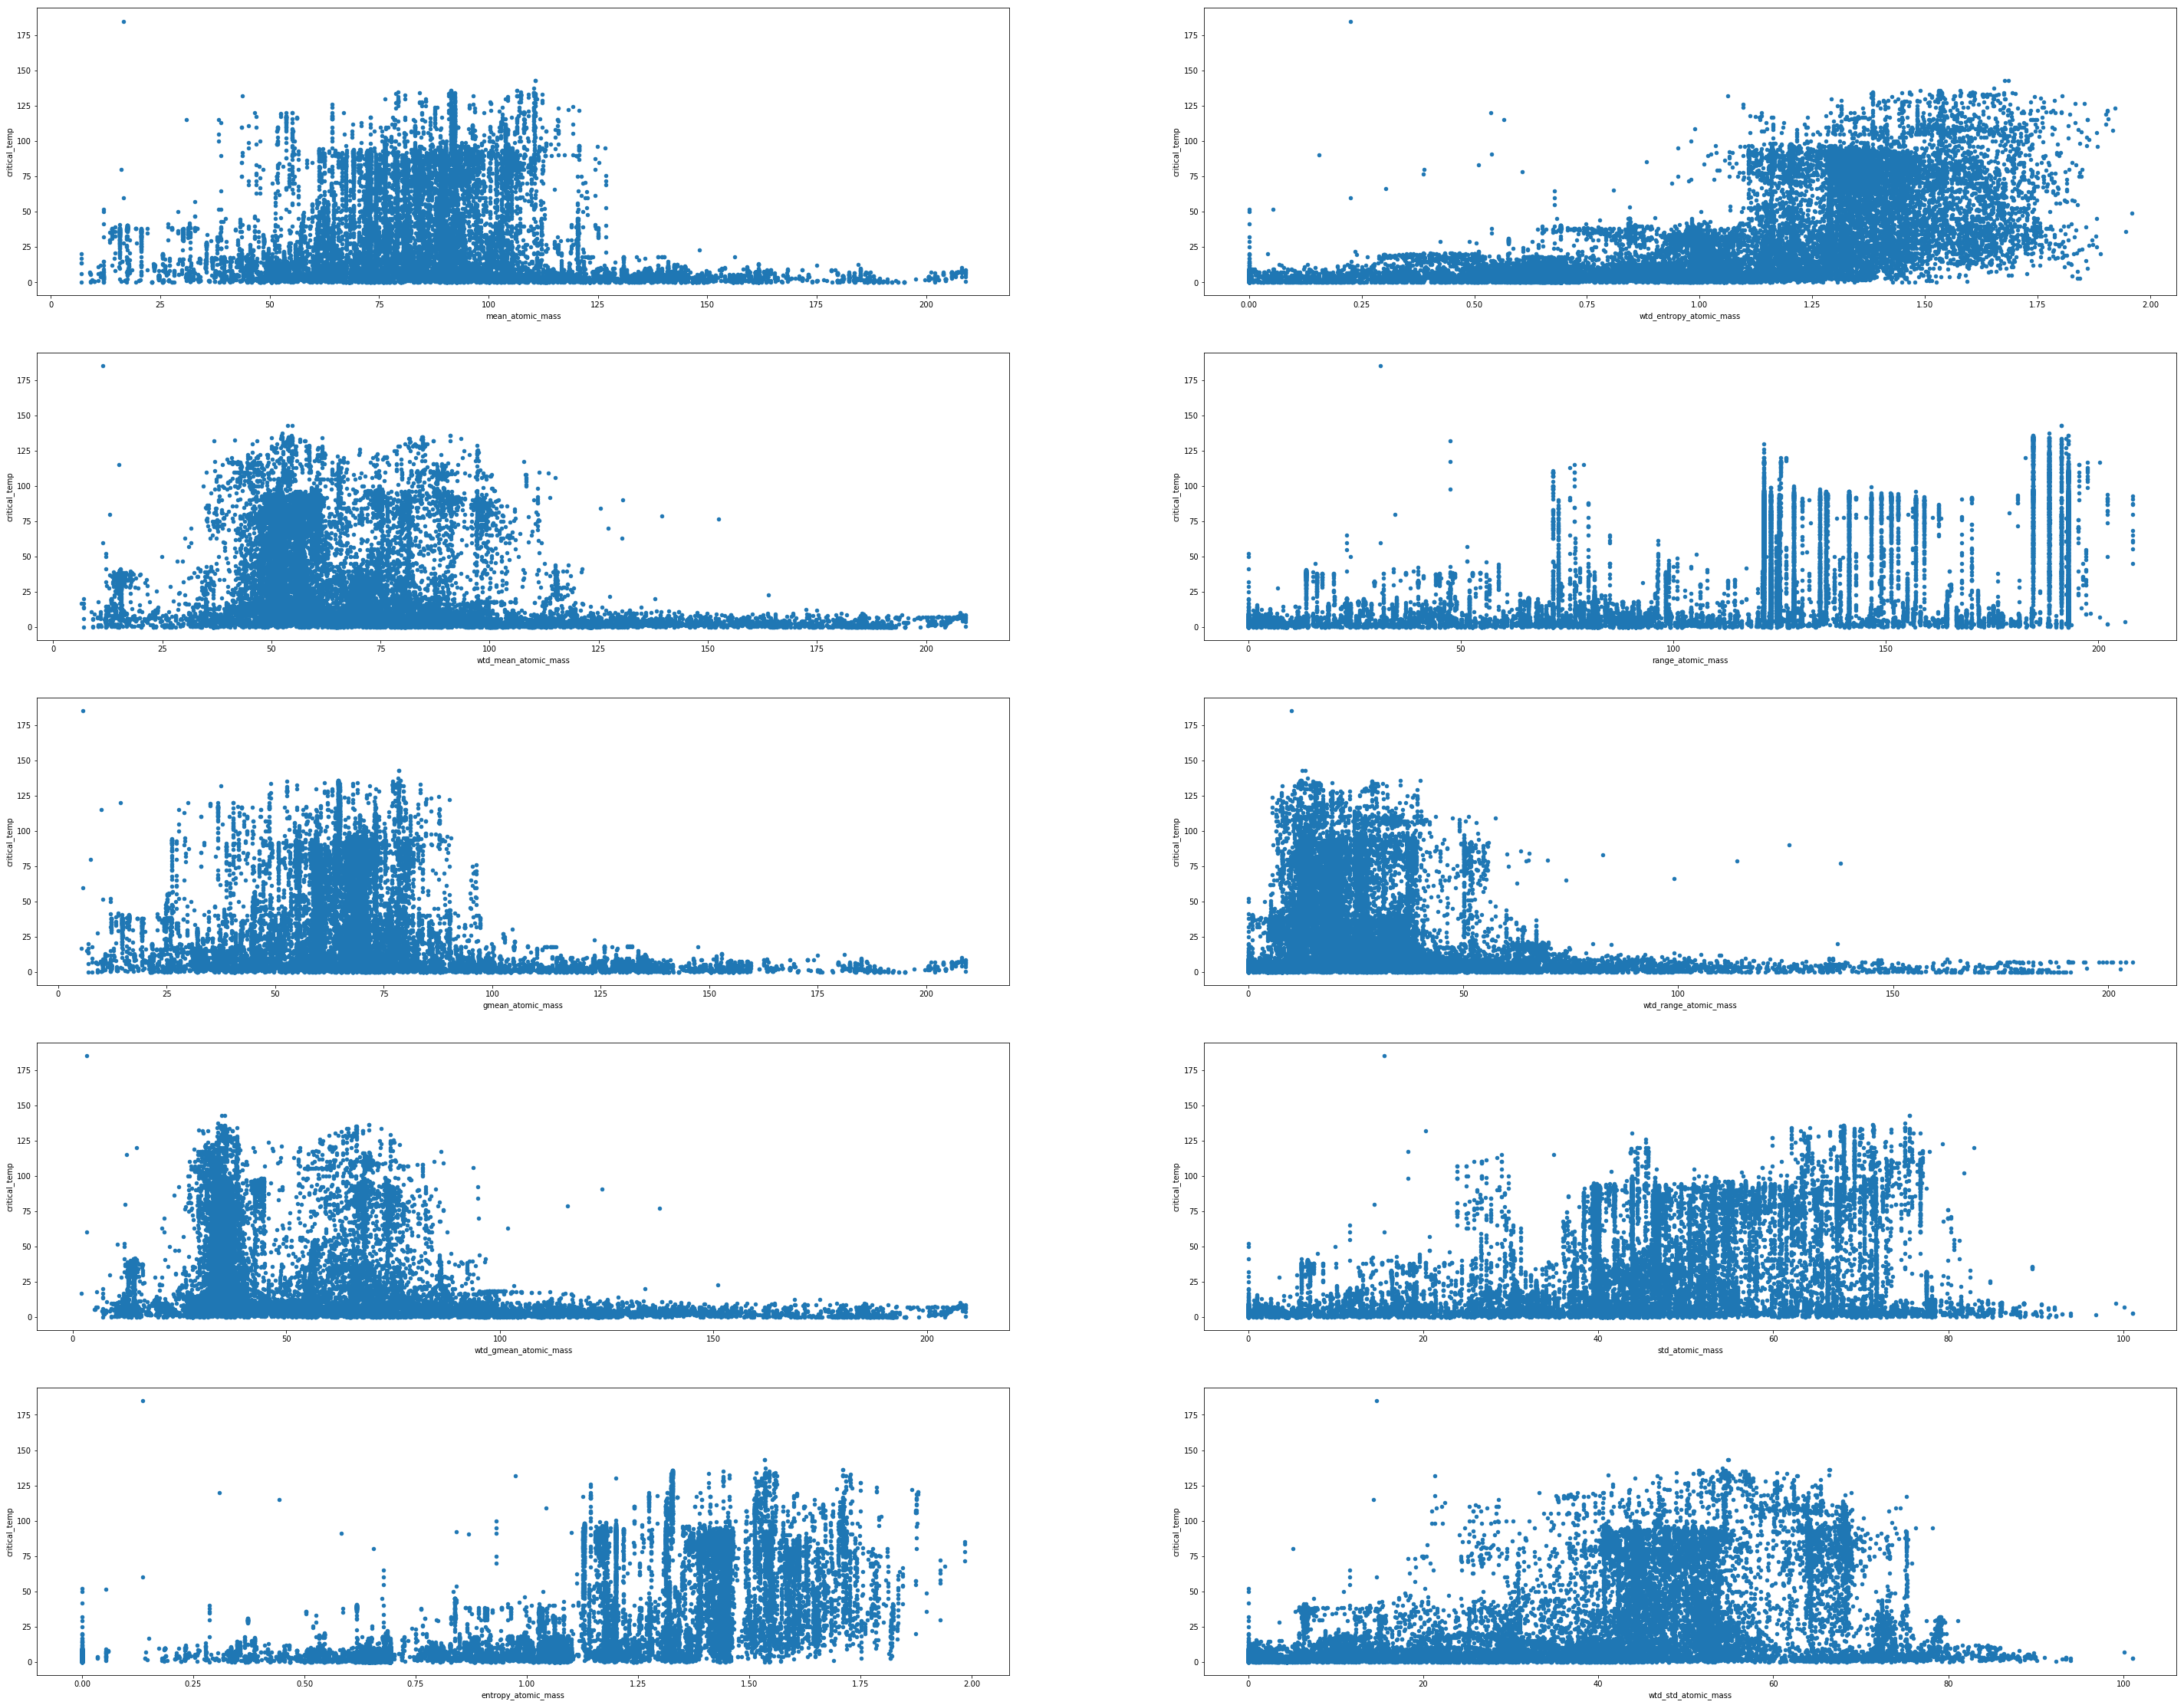

In [59]:
df.boxplot(by='number_of_elements', 
                       column=['critical_temp'], 
                       grid=False)

df.plot.scatter(x='number_of_elements', y='critical_temp')

fig, axes = plt.subplots(5, 2, figsize=(50,40))

df.plot.scatter(x='mean_atomic_mass', y='critical_temp',  ax=axes[0,0])
df.plot.scatter(x='wtd_mean_atomic_mass', y='critical_temp',ax=axes[1,0])
df.plot.scatter(x='gmean_atomic_mass', y='critical_temp',ax=axes[2,0])
df.plot.scatter(x='wtd_gmean_atomic_mass', y='critical_temp',ax=axes[3,0])
df.plot.scatter(x='entropy_atomic_mass', y='critical_temp',ax=axes[4,0])

df.plot.scatter(x='wtd_entropy_atomic_mass', y='critical_temp',  ax=axes[0,1])
df.plot.scatter(x='range_atomic_mass', y='critical_temp',ax=axes[1,1])
df.plot.scatter(x='wtd_range_atomic_mass', y='critical_temp',ax=axes[2,1])
df.plot.scatter(x='std_atomic_mass', y='critical_temp',ax=axes[3,1])
df.plot.scatter(x='wtd_std_atomic_mass', y='critical_temp',ax=axes[4,1])


### Bivariate analysis cont.

For _number of elements_, 1,2, and 3 are mostly in the lower temperature range, with an outlier and some higher temperatures falling in the 3 element category.  A broad range of temperatures are covered by elements with 4-7 element. A middle range of temperates for those with 8 and 9 elements.
The distribution of number of elements have a majority with 5 and 4 elements which have the broad range of temperatures.  This feature alone, looks like it will help identify a critical temperature better for the 1,2,9 and 8 elements better than the rest.

Similiarly, for the element and properties, there is not a correlation across the range of values to temperature. Some ranges for the features fall into a narrow band of critical temperatures.  

In [60]:
def normality_checks(feature_col):
    """
 will take in the feature column, series (slice) of the pandas df then
    1. plot the qqplot, 
    2. print the Shapiro-Wilk stats and pvalue
    3. skew and kurtosis normal test stats, 
    4. the anderson test results
    """
    print("\nResults of normality tests for the {0} feature:".format(feature_col.name))
    qqplot(feature_col, line='s')
    #plt.show()
    stat, p = shapiro(feature_col)
    if feature_col.shape[0]>5000:
        print("Note: in the Shapiro-Wilk test for normality: for N > 5000 the W test statistic is accurate but the p-value may not be.")
    print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
    stat, p = normaltest(feature_col)
    print('D’Agostino’s K^2 Test statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does NOT look Gaussian (reject H0)')
    result = anderson(feature_col)
    print('Anderson-Darling test statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does NOT look normal (reject H0)' % (sl, cv))
 

In [61]:
#every feature did not pass any normality test, so I used RobustScaler in the later cells
#for col in df.columns:
#    normality_checks(df[col])

In [101]:
#slice out the training and target data, then create the train test split
X=df.loc[:, df.columns != 'critical_temp']
y=df.critical_temp
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

<a id='dummyregressor'></a>
### DummyRegressor baseline
Compare to the result of using the mean to the created models - as a way to check there isnt a mistake with the data transformation of the features, or features are bad, or no point to an ML model.
The R2 score and RMSE shown below, confirms ML is the way to go.

In [63]:
dr=DummyRegressor(strategy='mean')
dr.fit(X_train,y_train)
print("R2 score of the dummy (mean) regressor: {0}".format(dr.score(X_test,y_test)))
scores = cross_val_score(dr, X, y, cv=3)
print(scores)
mean_squared_error(y_test, dr.predict(X_test)**0.5)

R2 score of the dummy (mean) regressor: -5.867508801049581e-07
[-1.67431442 -0.09564514 -2.20517812]


1978.6278543211122

In [64]:
def lg_model(X_train, X_test, y_train, y_test, num_folds):
    """ 
    Function to create a linear regression model
    Return the model object, as well as the scores on the test, train data
    cross validation scores
    """
    lg=linear_model.LinearRegression()
    lg.fit(X_train,y_train)
    y_pred=lg.predict(X_test)
    y_pred_train=lg.predict(X_train)
    rmse=mean_squared_error(y_test, y_pred)**0.5
    rmse_train=mean_squared_error(y_train, y_pred_train)**0.5
    test_score=lg.score(X_test,y_test)
    train_score=lg.score(X_train,y_train)
    X=pd.concat([X_train, X_test], axis=0)
    y=pd.concat([y_train, y_test], axis=0)
    scores = cross_val_score(lg, X, y, cv=num_folds)
    return (lg, test_score, train_score, rmse, rmse_train, scores)

In [65]:
lg_baseline, test_score, train_score, rmse, rmse_train, scores=lg_model(X_train, X_test, y_train, y_test, 3)
print("Results for the baseline linear regression model:")
print("test score={0}, train score={1}, \nRMSE={2} RMSE_training={3}, \nCV=3 scores={4}".format(test_score, train_score, rmse, rmse_train, scores))

Results for the baseline linear regression model:
test score=0.7395179885627364, train score=0.7358661992462201, 
RMSE=17.41539809701146 RMSE_training=17.63297894865532, 
CV=3 scores=[0.73751765 0.72764962 0.73983192]


<a id='linear_regression'></a>
### Linear Regression
- Initial results:

I get about the same score as the authors of the paper.  The train, test and CV score results do not show overfitting.

on to scaling ...

In [66]:

#try robust scaler first on the ind vars- see if this gives any lift and I found it hardly made a difference
x_robscaled=RobustScaler(quantile_range=(25, 75)).fit_transform(X)
#convert to a pandas dataframe with the headers
x_rscaled=pd.DataFrame(x_robscaled, dtype=float, columns=df.columns[df.columns != 'critical_temp'])
X_train_scaled_all, X_test_scaled_all, y_train_scaled_all, y_test_scaled_all = train_test_split(x_rscaled,y,test_size=0.3)
lg_r_scaled, test_score, train_score, rmse, rmse_train, scores=lg_model(X_train_scaled_all, X_test_scaled_all, y_train_scaled_all, y_test_scaled_all, 3)

print("Results for the robust scaled data linear regression model:")
print("test score={0}, train score={1}, \nRMSE={2} RMSE_training={3}, \nCV=5 scores={4}".format(test_score, train_score, rmse, rmse_train, scores))

Results for the robust scaled data linear regression model:
test score=0.7314331456348073, train score=0.739354710922983, 
RMSE=17.84326510469765 RMSE_training=17.447840148516242, 
CV=5 scores=[0.73213028 0.7419125  0.73107133]


<a id='feature_selection'></a>
### Feature Selection
Recursive feature elimination ([RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)) and SelectFromModel are demonstrated below. 

Results below show that reduced features reduces the R2 score slightly vs the above scores for the models that use all of the features.  This could be worth the slight predictive accuracy sacrifice for a simpler model, that uses less data.

In [30]:
from sklearn.feature_selection import RFE
selector = RFE(lg_r_scaled, 40, step=1)
selector = selector.fit(x_rscaled, y)
selected_feats=list(x_rscaled.columns[selector.get_support()])
print(selected_feats)

['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass', 'range_atomic_mass', 'std_atomic_mass', 'mean_fie', 'wtd_mean_fie', 'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'range_fie', 'std_fie', 'mean_atomic_radius', 'wtd_mean_atomic_radius', 'wtd_gmean_atomic_radius', 'entropy_atomic_radius', 'wtd_entropy_atomic_radius', 'range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius', 'wtd_mean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'range_ElectronAffinity', 'std_ElectronAffinity', 'wtd_std_ElectronAffinity', 'wtd_mean_FusionHeat', 'wtd_gmean_FusionHeat', 'wtd_mean_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 'range_ThermalConductivity', 'wtd_range_ThermalConductivity', 'std_ThermalConductivity', 'gmean_Valence', 'wtd_gmean_Valence', 'entropy_Valence', 'wtd_entropy_Valence', 'range_Valence', 'wtd_std_Valence']


In [31]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_rscaled[selected_feats],y,test_size=0.3)

lg_RFE_scaled, test_score, train_score, rmse, rmse_train, scores=lg_model(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, 5)
print("Results for the RFE linear regression model:")
print("test score={0}, train score={1}, \nRMSE={2} RMSE_training={3}, \nCV=5 scores={4}".format(test_score, train_score, rmse, rmse_train, scores))

Results for the RFE linear regression model:
test score=0.7245376805672963, train score=0.7191339601474706, 
RMSE=17.936411527596633 RMSE_training=18.170030470059853, 
CV=5 scores=[0.71942468 0.71592848 0.71429309 0.73227872 0.71734428]


In [33]:
from sklearn.linear_model import Ridge
ridge = Ridge()
from sklearn.feature_selection import SelectFromModel
featureSelection = SelectFromModel(ridge)
featureSelection.fit(x_rscaled, y)
selectedFeatures = featureSelection.transform(x_rscaled)
print(len(selectedFeatures[0]))
print(featureSelection)

30
SelectFromModel(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
        max_features=None, norm_order=1, prefit=False, threshold=None)


In [36]:
selected_feats=list(x_rscaled.columns[featureSelection.get_support()])

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_rscaled[selected_feats],y,test_size=0.3)

lg_SFM_scaled, test_score, train_score, rmse, rmse_train, scores=lg_model(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, 5)
print("Results for the SFM linear regression model:")
print("test score={0}, train score={1}, \nRMSE={2} RMSE_training={3}, \nCV=5 scores={4}".format(test_score, train_score, rmse, rmse_train, scores))

Results for the SFM linear regression model:
test score=0.6990651918060611, train score=0.7139178308614575, 
RMSE=18.770762440165946 RMSE_training=18.329342085706013, 
CV=5 scores=[0.71487689 0.70997461 0.71525682 0.69715732 0.70602633]


<a id='log_transform'></a>
#### Log transformation of the target to create non-linear targets
This gives a slight lift to the train and test score.

Results for the log y trans linear regression model:
test score=0.7585368933172641, train score=0.7658429361893433, 
RMSE=0.6318837270348433 RMSE_training=0.6246294462226822, 
CV=5 scores=[0.76805743 0.77202461 0.75087905 0.75817764 0.75826209]


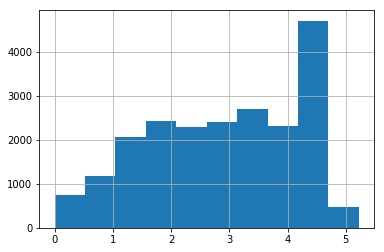

In [37]:
#log transform of the target - slightly improves the score
y_trans = np.log1p(y)
y_trans.hist()
X_train_lgy, X_test_lgy, y_train_lgy, y_test_lgy = train_test_split(x_rscaled,y_trans,test_size=0.3)
lg_log_y, test_score, train_score, rmse, rmse_train, scores=lg_model(X_train_lgy, X_test_lgy, y_train_lgy, y_test_lgy, 5)
print("Results for the log y trans linear regression model:")
print("test score={0}, train score={1}, \nRMSE={2} RMSE_training={3}, \nCV=5 scores={4}".format(test_score, train_score, rmse, rmse_train, scores))

<a id='linear_regression'></a>
### Regularization
My goal with the code below is to illustrate regularization.  It is not going to help linear regression on this data. It actually makes it worse, since overfitting on the training data was not a problem as it was similiar to the test result.  It is known there is non linearity in the data

Ridge and Lasso are used, first finding the best hyperparamters with gridcv search, then showing the results and difference to the non regularized model.  
Ridge will shrink coeffcients while Lasso shrinks coefficients but also can do a feature selection by zeroing out coefficients.

Ridge and Lasso have about the same best error.

In [38]:
#https://github.com/llSourcell/ISL-Ridge-Lasso/blob/master/Lasso%20and%20Ridge%20Regression.ipynb
from sklearn.model_selection import GridSearchCV


alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(x_rscaled,y)
print("RR l2 best score {0} and the params {1}".format(ridge_regressor.best_score_, ridge_regressor.best_params_))

RR l2 best score -357.22686295219233 and the params {'alpha': 5}


In [39]:
from sklearn.linear_model import Lasso

lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)

lasso_regressor.fit(x_rscaled,y)
print("Lasso l1 best score {0} and the params {1}".format(lasso_regressor.best_score_, lasso_regressor.best_params_))

Lasso l1 best score -359.32897142421126 and the params {'alpha': 0.001}


In [40]:
#checked for l1, l2 and elasticnet
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter=50, penalty='l2', eta0=0.1, alpha=5)
sgd_reg.fit(X_train_scaled_all,y_train_scaled_all)
#sgd_reg.coef_


#[i for i, j in zip(sgd_reg.coef_, lg_baseline.coef_) if i == j]
sgd_test_score=sgd_reg.score(X_test_scaled_all,y_test_scaled_all)
sgd_train_score=sgd_reg.score(X_train_scaled_all,y_train_scaled)
#default metric used, SGD R2
scores = cross_val_score(sgd_reg, x_rscaled,y, cv=5)
print("L2 results, test score={0} train score={1}\nCV=5 scores {2}".format(sgd_test_score,sgd_train_score, scores))


L2 results, test score=0.4567378688508653 train score=-0.24701212339842837
CV=5 scores [-0.08826664  0.00303482  0.44103617 -1.01858909 -0.05807985]


#### Visualization of the coefficients, before and after regularization

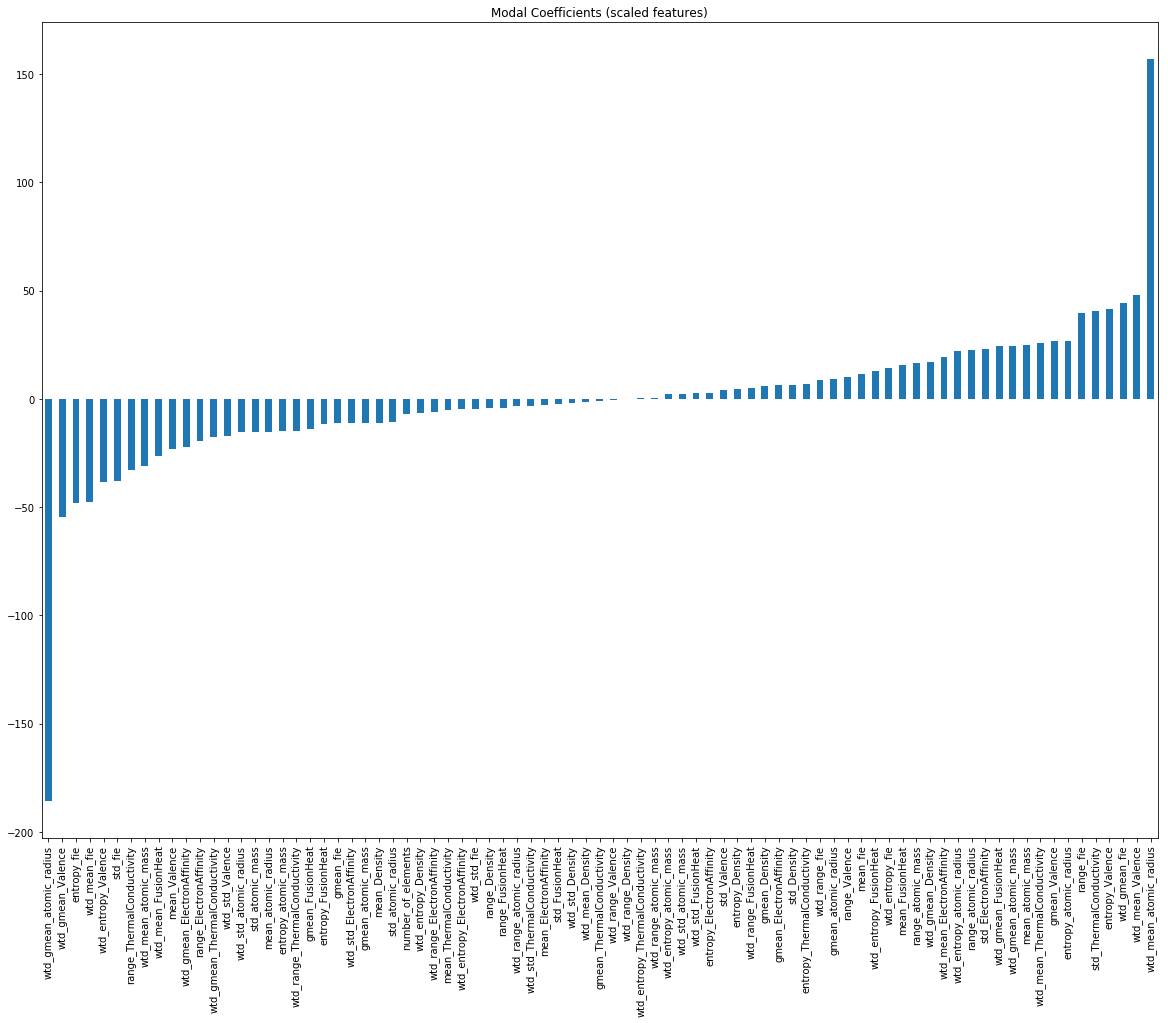

In [41]:
coef = pd.Series(lg_r_scaled.coef_,df.columns[df.columns != 'critical_temp']).sort_values()

coef.plot(kind='bar', title='Modal Coefficients (scaled features)', figsize=(20,15))

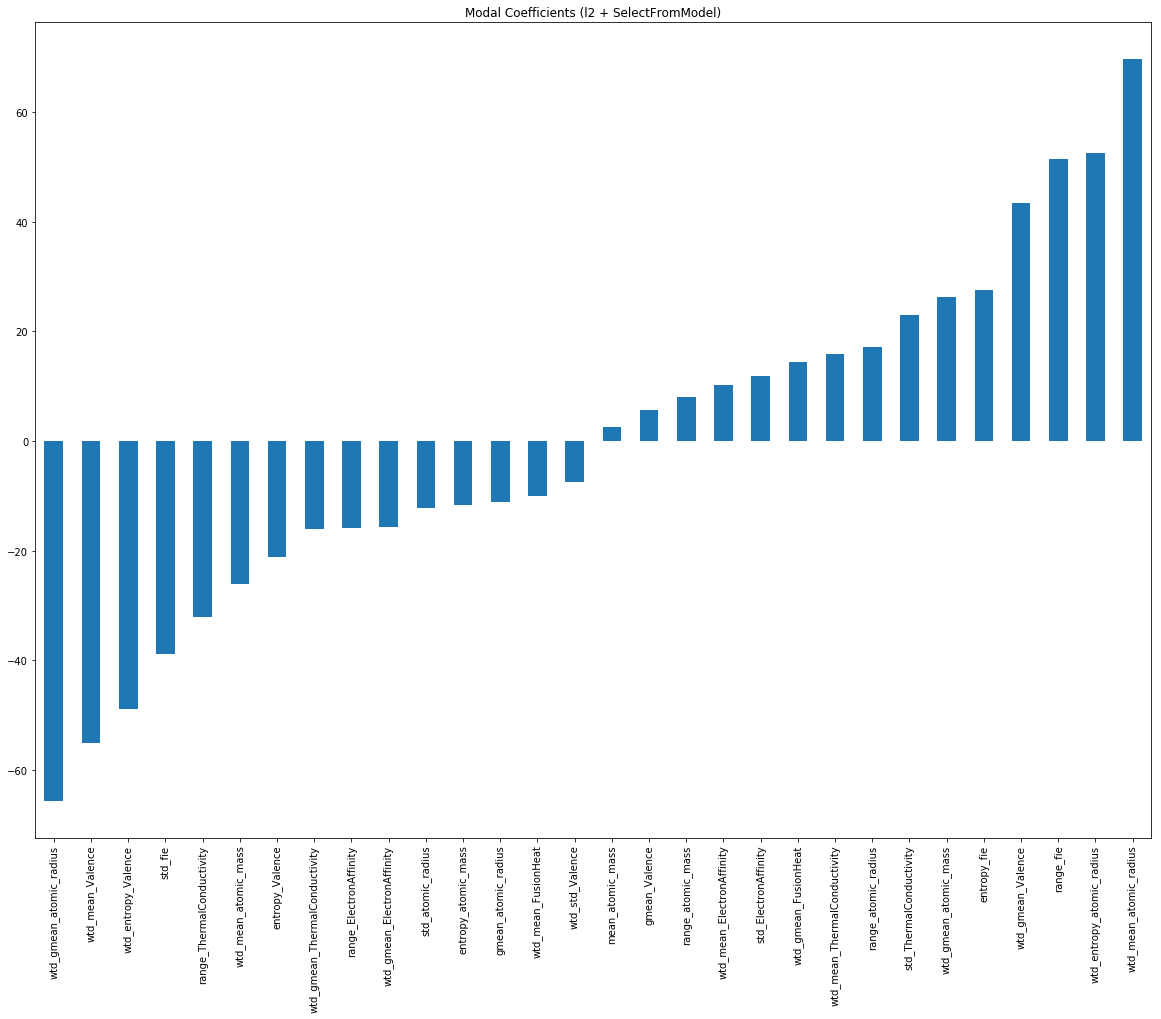

In [42]:
coef = pd.Series(lg_SFM_scaled.coef_,selected_feats).sort_values()

coef.plot(kind='bar', title='Modal Coefficients (l2 + SelectFromModel)', figsize=(20,15))

<a id='p_values'></a>
### P-values, statistical testing of the feature coefficients and high multicollinearity
With a smaller data test, performing significance testing on the weight of the variables, or relationship to the dependant variable, is helpful. That is, when you don't have enough data or are not sure you have enough to represent the entire population.

Below, statsmodels is used to calculate p-values for the coefficient of each feature.  If the p-value is less than .05, the null hypothesis is rejected and assume there is a signifcant relationship to the dependant variable.  My goal here is to illustrate a method to get a pvalue with the help of a built in function.  

In [69]:
#to get p-value and per-coefficient p-values.
#still ok to include in spite of VIF
#disclaimer about VIF are not what was expected, write about why I wanted to use it

import statsmodels.api as sm    
from statsmodels.tools.tools import add_constant
print(x_rscaled.columns)
X = add_constant(x_rscaled)

ols_mod = sm.OLS(y_trans,X)
ols_res = ols_mod.fit()

print(ols_res.summary())
print(ols_res.pvalues[ols_res.pvalues>=0.05])
insig_cols=list(ols_res.pvalues[ols_res.pvalues>=0.05].index)
print(len(insig_cols))

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

<a id='vif'></a>
#### Variance inflation factor (VIF)

17 of the variables have a p-value higher than .05, which could show the rest of the independant variables are statistically significant.  

A way to measure the correlation between the independant variables is with the variance inflation factor (VIF).  If this value is high for a variable, then that high correlation means the variable is not really independant.

The results below show that the VIF values for all of the variables are greater than 5, which is very high, and means p-values are not reliable.  The paper's author using this data had stated there was high correlation in the variables and I assume the conversions of the elements to various units are a relationship of the original element.

I ran this on the already robust scaled values, so scaling to reduce multicollinearity will not help. It could be possible to still go with a linear regression if interpreting the coefficients of the model to the dependant variable is not important, and having decent predictions is the only goal.  More good information [here](https://statisticalhorizons.com/multicollinearity).

In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#possible similiar numeric problem
#try excluding the interaction 
X.drop_duplicates()
X = add_constant(x_rscaled)
vif_values=pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)


print(len(vif_values[vif_values>25]))

scaler = StandardScaler().fit(x_rscaled)
xtd=scaler.transform(x_rscaled)

Xtd = add_constant(xtd)
vif_values=pd.Series([variance_inflation_factor(Xtd, i) 
               for i in range(Xtd.shape[1])], 
              index=X.columns)
print(vif_values[0:50])
print(vif_values[50:85])
#high_vif=list(vif_values[vif_values.index>=1].index)

high_vif = vif_values[vif_values >= 5]
print(len(high_vif))

# X2=X.loc[:,['mean_atomic_mass','entropy_fie','range_atomic_radius','std_ThermalConductivity', 'wtd_std_ElectronAffinity','mean_ThermalConductivity']]

# print(X2.columns)
# vif_values=pd.Series([variance_inflation_factor(X2, i) 
#                for i in range(X2.shape[1])], 
#               index=X2.columns)
# print(vif_values)

78
const                              1.000000
number_of_elements                79.644423
mean_atomic_mass                 414.277383
wtd_mean_atomic_mass             818.370293
gmean_atomic_mass                444.203673
wtd_gmean_atomic_mass            879.861538
entropy_atomic_mass              193.544013
wtd_entropy_atomic_mass          146.536977
range_atomic_mass                 56.020194
wtd_range_atomic_mass             24.351696
std_atomic_mass                  108.620579
wtd_std_atomic_mass               81.931661
mean_fie                        2113.200741
wtd_mean_fie                    8433.871750
gmean_fie                       1654.308790
wtd_gmean_fie                   5748.351774
entropy_fie                     4085.867992
wtd_entropy_fie                  174.834966
range_fie                        270.679817
wtd_range_fie                     45.381485
std_fie                          416.708743
wtd_std_fie                      477.700953
mean_atomic_radius           

<a id='residuals'></a>
#### Residual Plot
Another check when using linear regression is on the residuals. One of the assumptions of the OLS linear regression model is that the errors (residuals) are random.  In the plot of residuals below is not random, or randomly scattered about the zero axis.  There is not enough information in the independant variables and some of that information is in the error terms. 

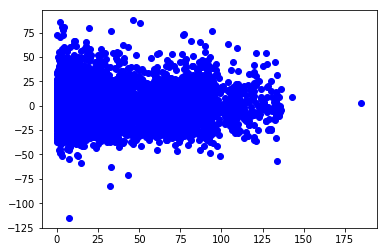

In [45]:
#the residual plot is not completely random

y_pred=lg_r_scaled.predict(X_test_scaled_all)
#plt.scatter(y_pred, (y_pred - y_test_scaled), c='b')
plt.scatter(y_test_scaled, (y_pred - y_test_scaled_all), c='b')
#shows non linearity in the data that the model does not 

<a id='non_linearity'></a>
### Dealing with Non-linearity
Polynomial and interaction terms can be used in linear regression to deal with non-linearity - I don't have domain knowledge to come up with these so brute force generation would be required and a selection of those features.  It makes the model more complex, and increases multicollinearity. Might be worth going straight to non-linear models but the downside is interpretability. There are some ways to get understanding of other models with some techniques out there, such as the [lime package](https://github.com/marcotcr/lime).

<a id='xgb'></a>
On to the popular XGBoost ... 

In [46]:
import xgboost as xgb

# XGBoost has an internal feature importance.  

xgb_model=xgb.XGBRegressor()
#X_train_lgy, X_test_lgy, y_train_lgy, y_test_lgy

xgb_model.fit(X_train_lgy, y_train_lgy)
score=xgb_model.score(X_test_lgy,y_test_lgy)  
rmse = mean_squared_error(y_test_lgy, xgb_model.predict(X_test_lgy))**0.5
print("XGBRegressor results using the log transformed target")
print("Score: {0}, RMSE: {1}".format(score, rmse))
scores = cross_val_score(xgb_model, x_rscaled,y_trans, cv=6)
print("Cross validation scores: {0}".format(scores))
score_train=xgb_model.score(X_train_lgy, y_train_lgy)
print("Score on the training set: {0}\n".format(score_train))

xgb_model2=xgb.XGBRegressor()
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled
xgb_model2.fit(X_train_scaled, y_train_scaled)
score2=xgb_model2.score(X_test_scaled,y_test_scaled)  
rmse2 = mean_squared_error(y_test_scaled, xgb_model2.predict(X_test_scaled))**0.5
score_train2=xgb_model2.score(X_train_scaled, y_train_scaled)
print("XGBRegressor results using the scaled robust")
print("Score: {0}, RMSE: {1}".format(score2, rmse2))
scores2 = cross_val_score(xgb_model2, X, y_trans, cv=6)
print("Cross validation scores: {0}".format(scores2))
print("Score on the training set: {0}".format(score_train2))

XGBRegressor results using the log transformed target
Score: 0.8466360439987957, RMSE: 0.5035857477031793
Cross validation scores: [0.55080882 0.49133543 0.76805095 0.50071531 0.71470636 0.3555906 ]
Score on the training set: 0.8572632029548084

XGBRegressor results using the scaled robust
Score: 0.8463803901566959, RMSE: 13.411242955752524
Cross validation scores: [0.55080882 0.49133543 0.76805095 0.50071531 0.71470636 0.3555906 ]
Score on the training set: 0.8632746873955408


It has a better score, but the cross validation results are not so great. This requires more investigation, and outside the scope of what I wanted to illustrate in this notebook, but ill use gridcv for a quick way to find possible better XGB regressor's hyperparameters.

In [52]:
# default is tree
xgb1 = xgb.XGBRegressor()


parameters = {#'njobs':[4], 
    # linear regression
              'objective':['reg:linear'],
    #Step size shrinkage used in update to prevents overfitting
    #didnt have to deal with overfitting in the linear model, but curious to see the result
              'learning_rate': [.01,.03, 0.05, .1,.2,.7,1], 
    # the higher the value the higher the complexity 
              'max_depth': [3,5,8,10],
    #minimum number of instances needed to be in each node. Trying higher values
              'min_child_weight': [1,3,5],
    #Subsample ratio of the training instances
    #sampling all should be fine, since no previous overfit issue
              'subsample': [.5,1],
    #subsample ratio of columns when constructing each tree, 1, I assume, should be fine
              'colsample_bytree': [.5,1],
    #try a relatively small amount of trees
              'n_estimators': [50, 200, 500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 3,
                        verbose=True)

xgb_grid.fit(X_train_scaled_all,y_train_scaled_all)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 11.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 27.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 47.4min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed: 76.0min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 122.4min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 197.3min
[Parallel(n_jobs=3)]: Done 3024 out of 3024 | elapsed: 264.8min finished


0.9168716078345825
{'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 1}


Results of the hyperparameter search above:

`
{'colsample_bytree': 0.5, 
 'learning_rate': 0.03, 
 'max_depth': 10, 
 'min_child_weight': 3, 
 'n_estimators': 500, 
 'objective': 'reg:linear', 
 'subsample': 1}
`

From these results, I see that for the best score, half the columns were sampled for each tree vs all columns, a relatively smaller learning rate, the max integer I set for max tree depth, the middle value for minimum child weight and did sample all of the training instances.

Based on these results, I will one more iteration varying 500 + trees n_estimators. below are the results of that. not much change in the score, and parameters chosen slightly changed for learning rate, max depth, minimum child weight.  But a score of .90+, is improvement to the efforts on the linear regression model attempts.


In [53]:
xgb2 = xgb.XGBRegressor()


parameters = { 
    # linear regression
              'objective':['reg:linear'],
    #Step size shrinkage used in update to prevents overfitting
    #didnt have to deal with overfitting in the linear model, but curious to see the result
              'learning_rate': [.01,.02,.03,], 
    # the higher the value the higher the complexity 
              'max_depth': [10, 20,30],
    #minimum number of instances needed to be in each node. Trying higher values
              'min_child_weight': [3,5],
    #Subsample ratio of the training instances
    #sampling all should be fine, since no previous overfit issue
              'subsample': [1],
    #subsample ratio of columns when constructing each tree, 1, I assume, should be fine
              'colsample_bytree': [.5,1],
    #try a relatively small amount of trees
              'n_estimators': [500, 1000]}

xgb_grid2 = GridSearchCV(xgb2,
                        parameters,
                        cv = 3,
                        n_jobs = 3,
                        verbose=True)

xgb_grid2.fit(X_train_scaled_all,y_train_scaled_all)

print(xgb_grid2.best_score_)
print(xgb_grid2.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 22.2min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 143.4min
[Parallel(n_jobs=3)]: Done 216 out of 216 | elapsed: 173.0min finished


0.9177804945858915
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:linear', 'subsample': 1}


<a id='gam'></a>
#### GAMs and general interpretability
If interpretability is important, [generalized additive models](https://multithreaded.stitchfix.com/blog/2015/07/30/gam/) (GAMs) is a choice, which I have implemented below . It got a decent score of .84.

[There are others](https://towardsdatascience.com/interpretability-in-machine-learning-70c30694a05f), as described in the [ESL book](https://books.google.com/books?id=tVIjmNS3Ob8C&pg=PA328&lpg=PA328&dq=MARS+Elements+of+statistical+learning&source=bl&ots=ENG8R7K4Wa&sig=ACfU3U18e0pxcV7KmzjMW_qYHGcqvpitYw&hl=en&sa=X&ved=2ahUKEwicwaL-p43hAhVumuAKHZhvD40Q6AEwCHoECAIQAQ#v=onepage&q=MARS%20Elements%20of%20statistical%20learning&f=false), Multiple Adaptive Regression Splines (MARS)


In [88]:
from pygam import LinearGAM


gam = LinearGAM(n_splines=10)
gam.fit(X_train_scaled_all,y_train_scaled_all)
print(gam.summary())# .score(X_test_scaled_all,y_test_scaled_all)  
gam.gridsearch(X_train_scaled_all,y_train_scaled_all)

#gam = LinearGAM(n_splines=10).gridsearch(X, y)
#gam.summary()


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    456.3161
Link Function:                     IdentityLink Log Likelihood:                                -93210.5442
Number of Samples:                        14884 AIC:                                           187335.7206
                                                AICc:                                          187364.7793
                                                GCV:                                              220.9215
                                                Scale:                                            208.7643
                                                Pseudo R-Squared:                                   0.8267
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:01:39 Time:  0:01:39


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34) + s(35) + s(36) + s(37) + s(38) + s(39) + s(40) + s(41) + s(42) + s(43) + s(44) + s(45) + s(46) + s(47) + s(48) + s(49) + s(50) + s(51) + s(52) + s(53) + s(54) + s(55) + s(56) + s(57) + s(58) + s(59) + s(60) + s(61) + s(62) + s(63) + s(64) + s(65) + s(66) + s(67) + s(68) + s(69) + s(70) + s(71) + s(72) + s(73) + s(74) + s(75) + s(76) + s(77) + s(78) + s(79) + s(80) + intercept,
   tol=0.0001, verbose=False)

In [85]:
from sklearn.metrics import r2_score
#gam.coef_# 
predictions = gam.predict(X_test_scaled_all)
print("R2 with GAM: {} ".format(r2_score(y_test_scaled_all, predictions)))


R2 with GAM: 0.8425444631052335 


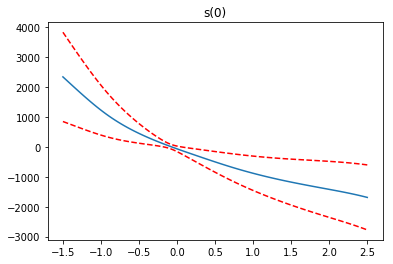

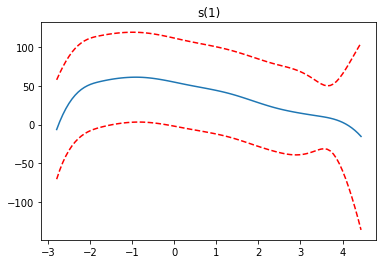

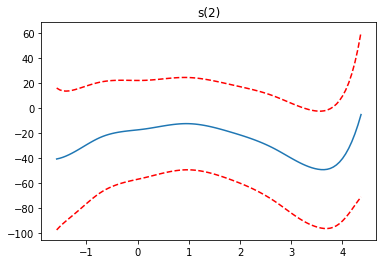

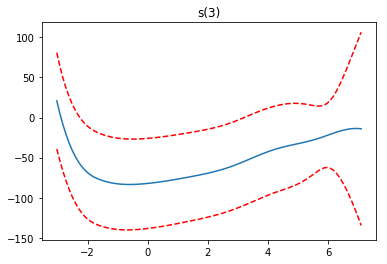

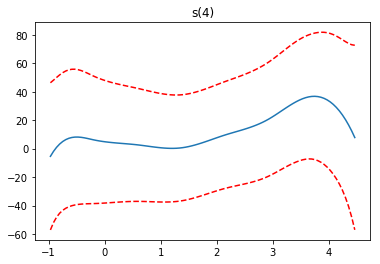

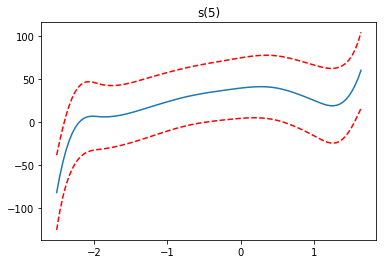

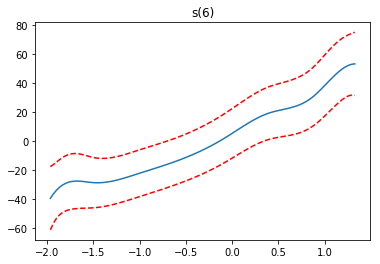

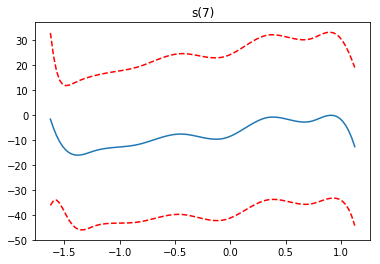

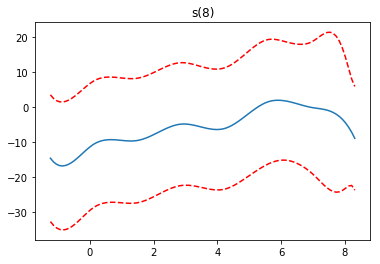

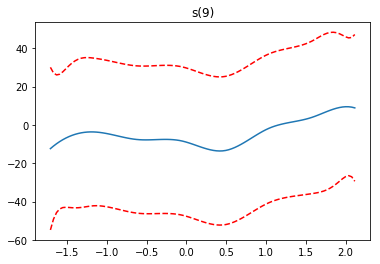

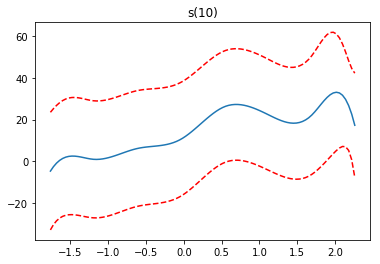

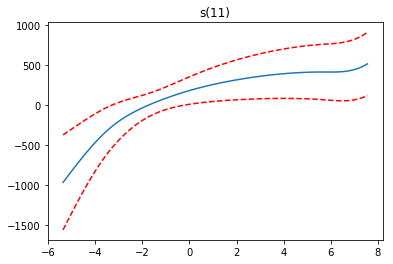

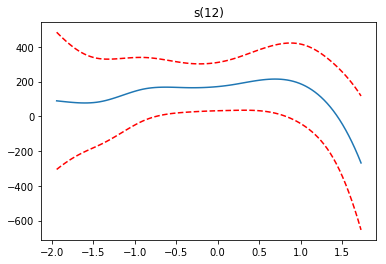

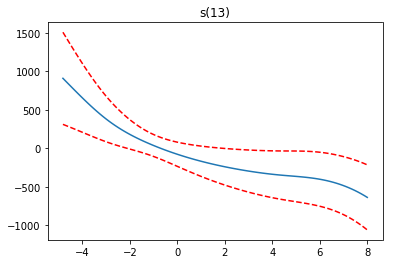

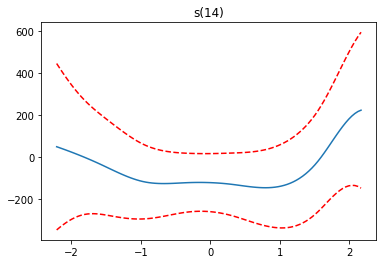

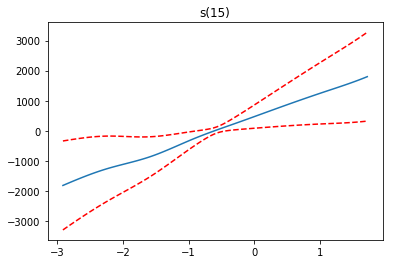

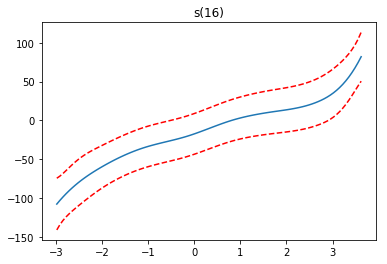

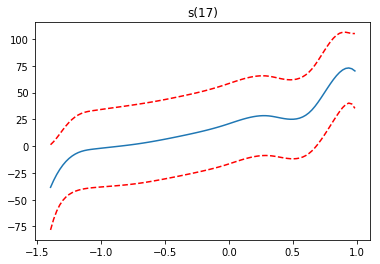

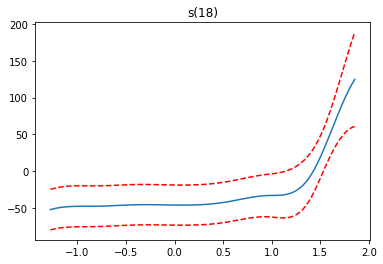

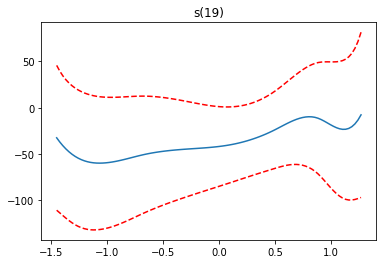

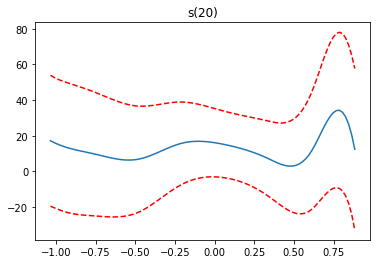

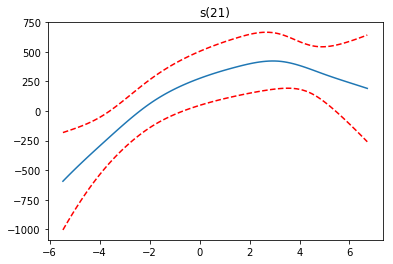

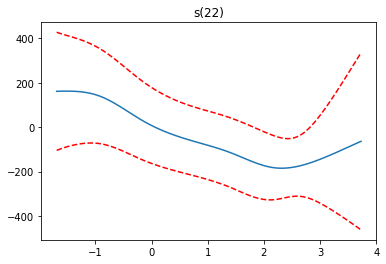

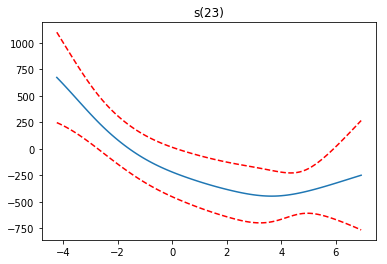

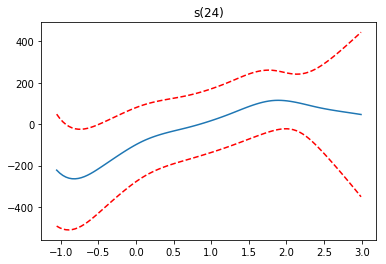

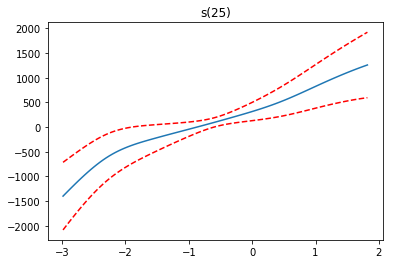

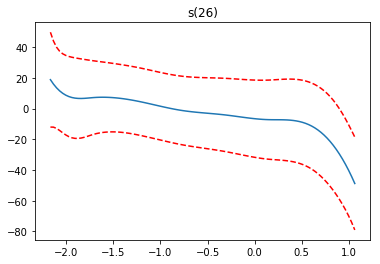

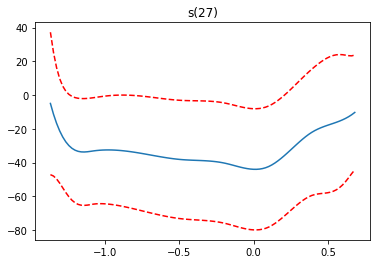

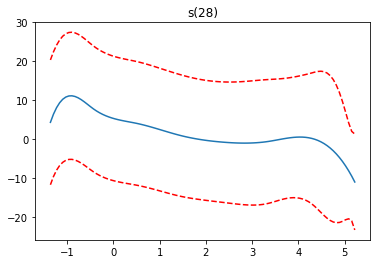

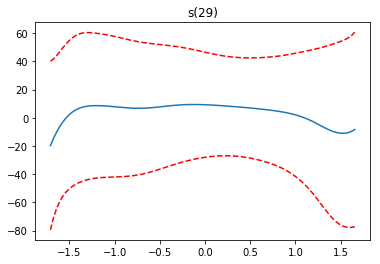

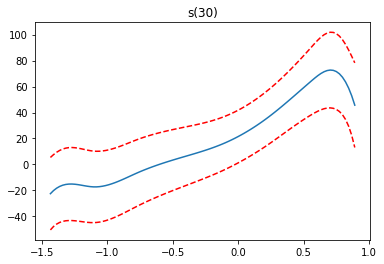

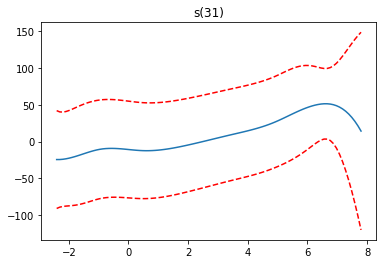

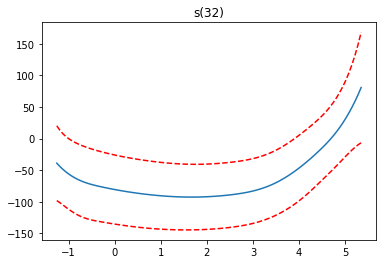

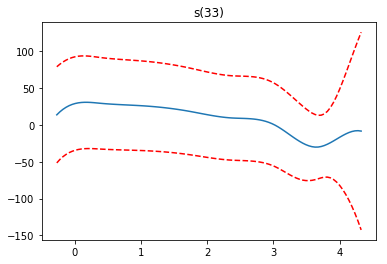

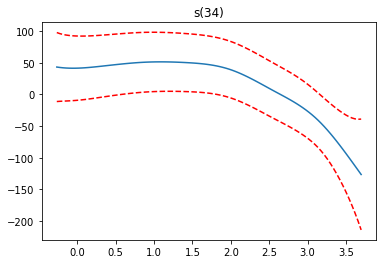

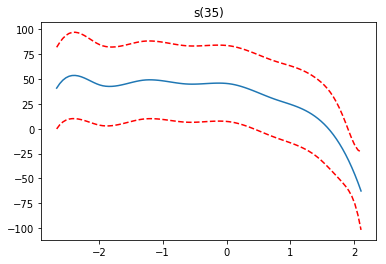

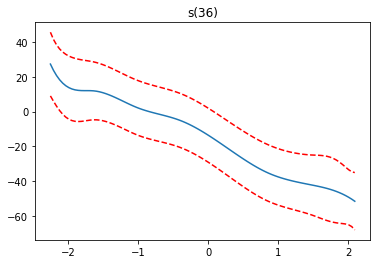

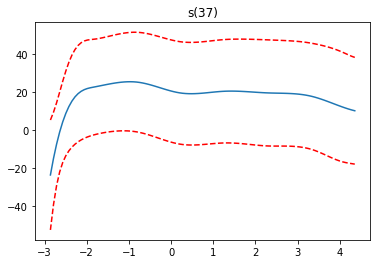

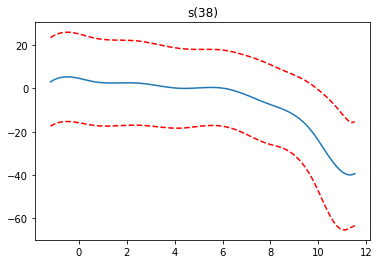

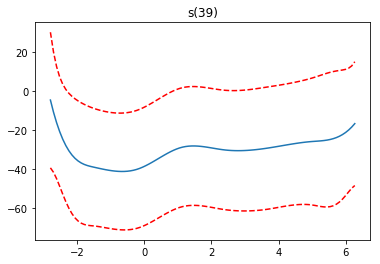

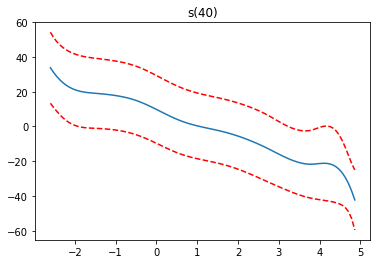

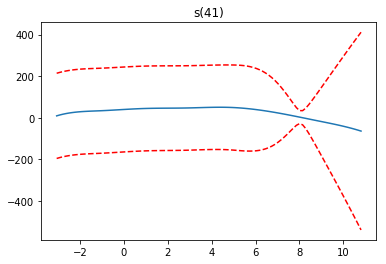

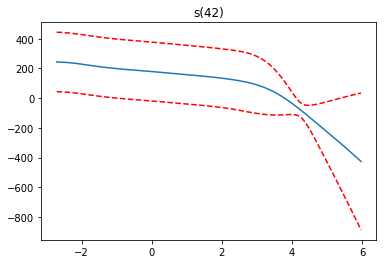

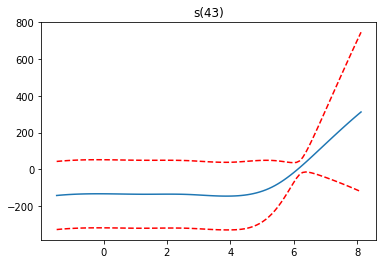

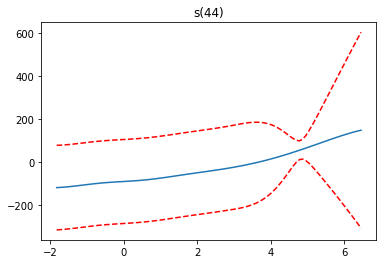

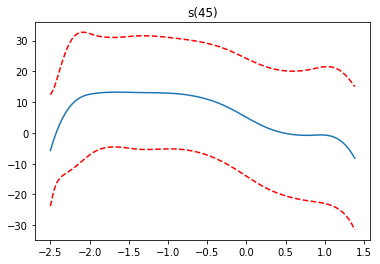

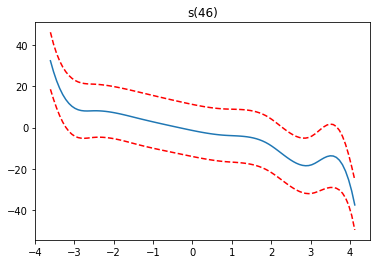

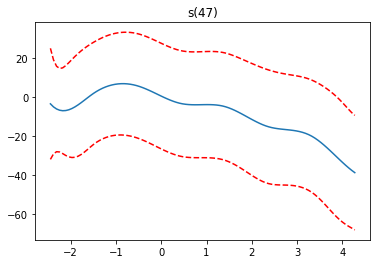

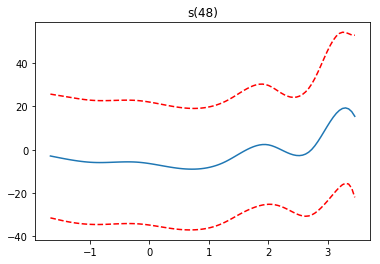

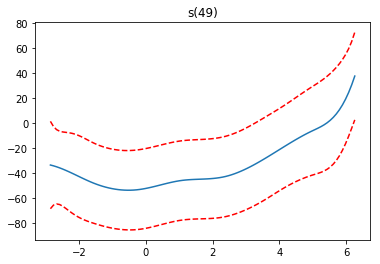

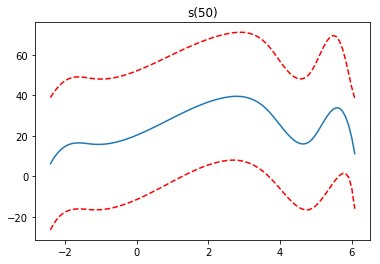

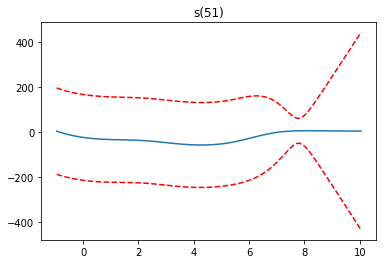

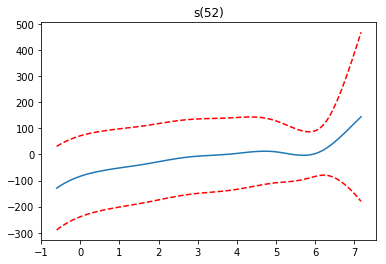

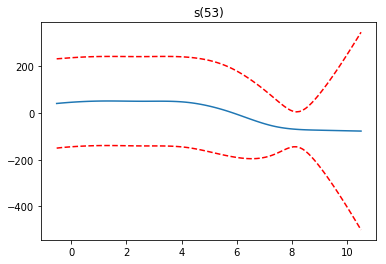

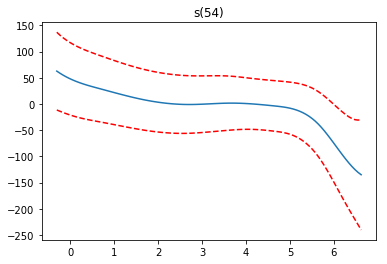

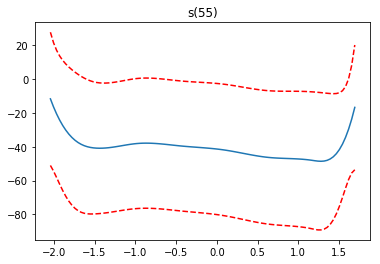

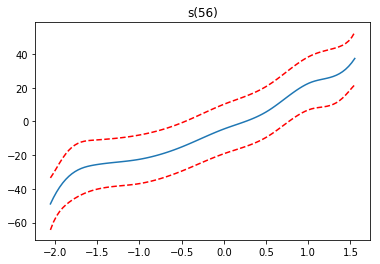

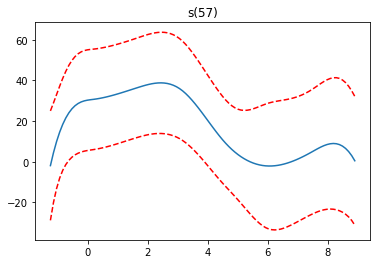

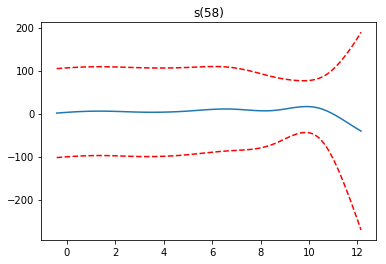

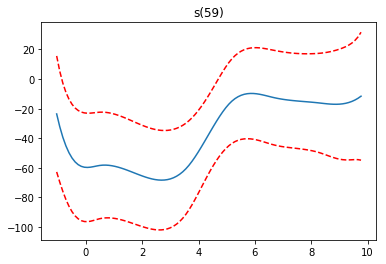

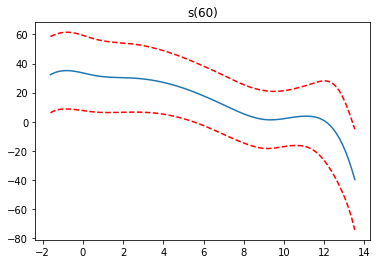

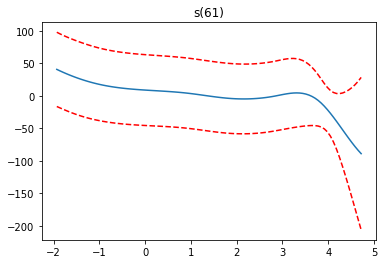

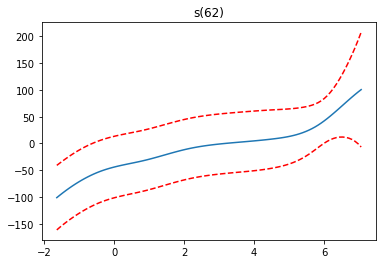

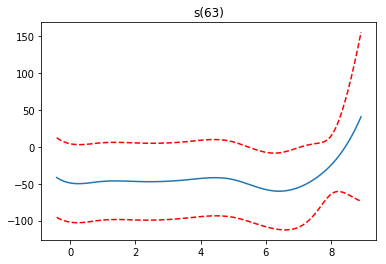

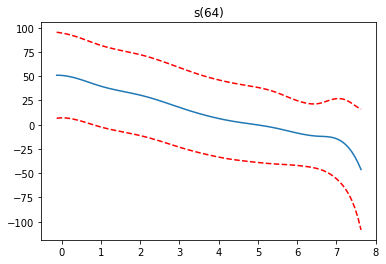

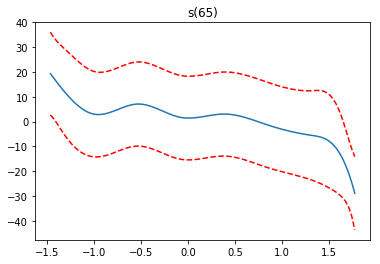

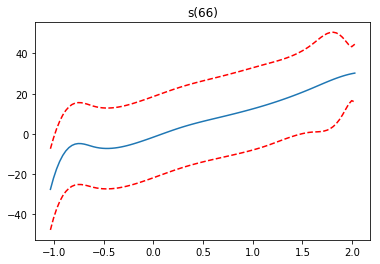

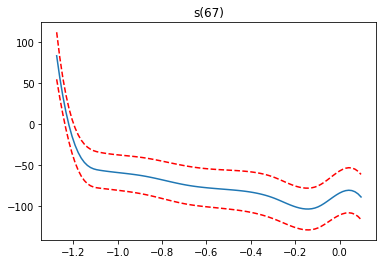

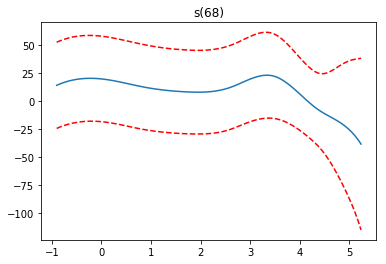

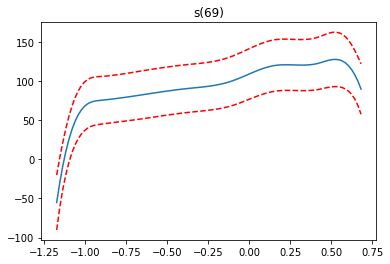

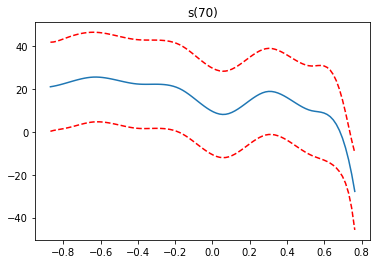

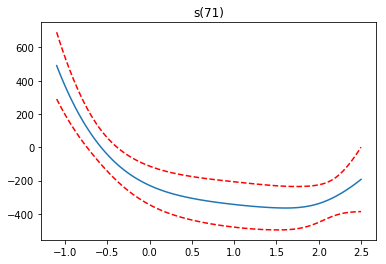

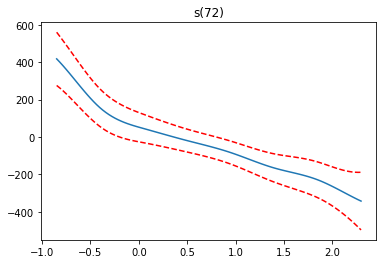

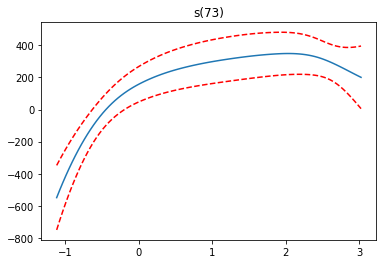

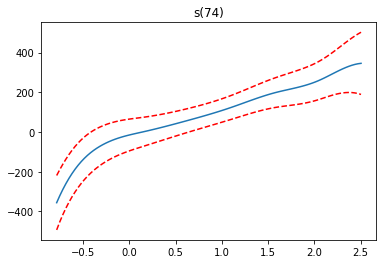

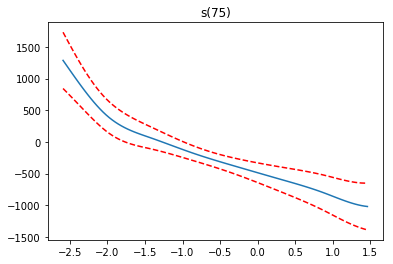

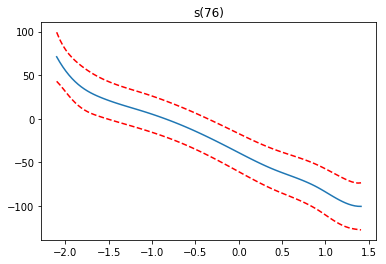

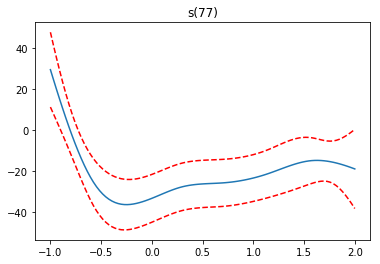

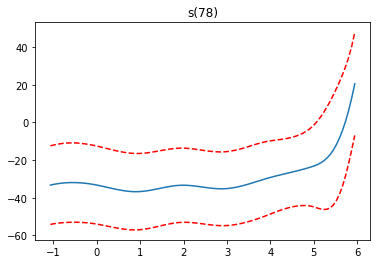

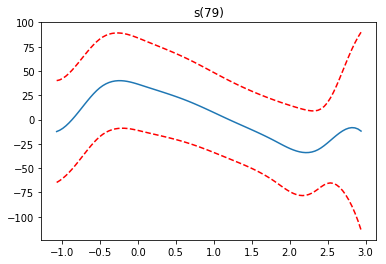

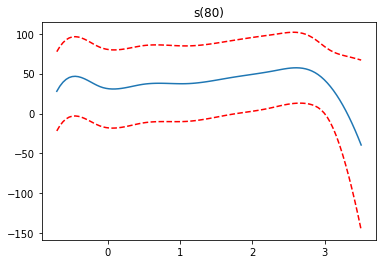

In [92]:
#Partial Dependence Functions - visualize each features contribution to the prediction.  The band shown is a 95% confidence interval.

for i, term in enumerate(gam.terms): 
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()